In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

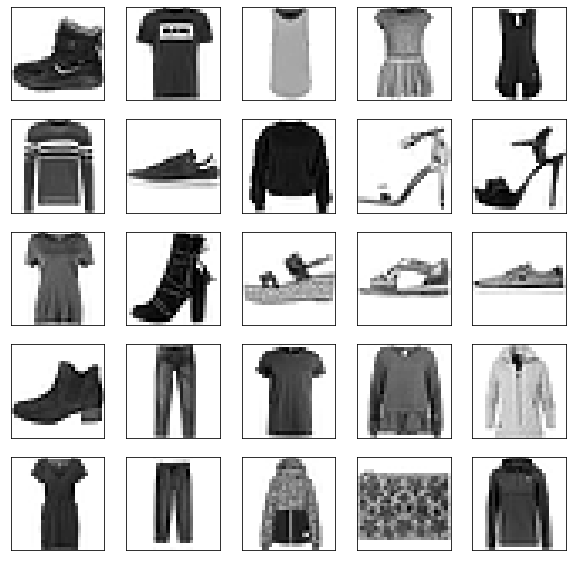

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
#Creates a Dataset that prefetches elements from this dataset

In [ ]:
num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

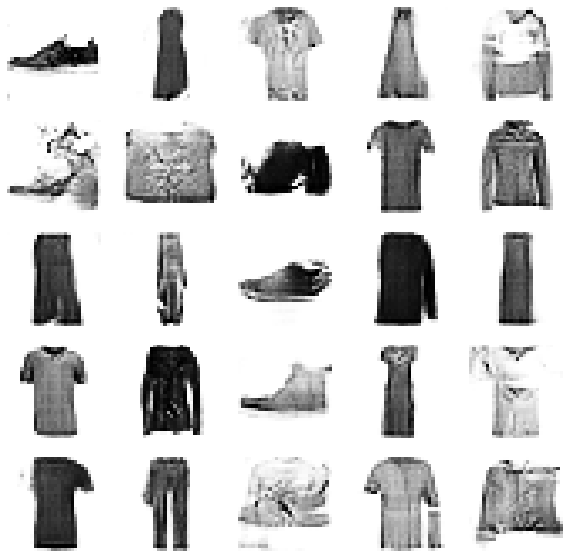

CPU times: user 2h 36min 27s, sys: 12min 52s, total: 2h 49min 20s
Wall time: 1h 35min 17s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


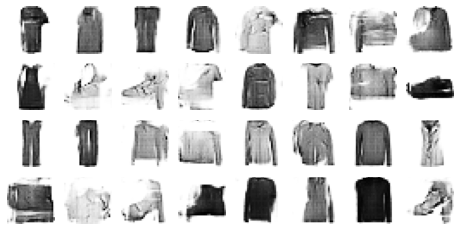

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)